In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuración de números flotantes a 3 decimales
pd.set_option('display.float_format','{:.2f}'.format)

# Estilo de visualización
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

## CARGA Y EXPLORACIÓN DE DATOS

In [3]:
# DATA PATH
DATA_PATH = os.path.join('../datasets/processed/rfm_dataset.csv')

In [4]:
# Carga de datos
data = pd.read_csv(DATA_PATH, index_col='Customer ID')
data.sample(5)

,Recency,Frequency,MonetaryValue
Customer ID,,,
DL-13495,77,12,-52.79
DJ-13510,49,13,345.25
AB-10255,167,14,264.57
DA-13450,353,8,56.79
JF-15190,66,19,575.13


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, AA-10315 to ZD-21925
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        793 non-null    int64  
 1   Frequency      793 non-null    int64  
 2   MonetaryValue  793 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 24.8+ KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,793.00,147.80,186.21,1.00,31.00,76.00,184.00,1166.00
Frequency,793.00,12.60,6.24,1.00,8.00,12.00,16.00,37.00
MonetaryValue,793.00,361.16,894.26,-6626.39,36.61,227.83,560.01,8981.32


In [7]:
data.columns

Index(['Recency', 'Frequency', 'MonetaryValue'], dtype='object')

#### VARIABLES SIN ESCALADO

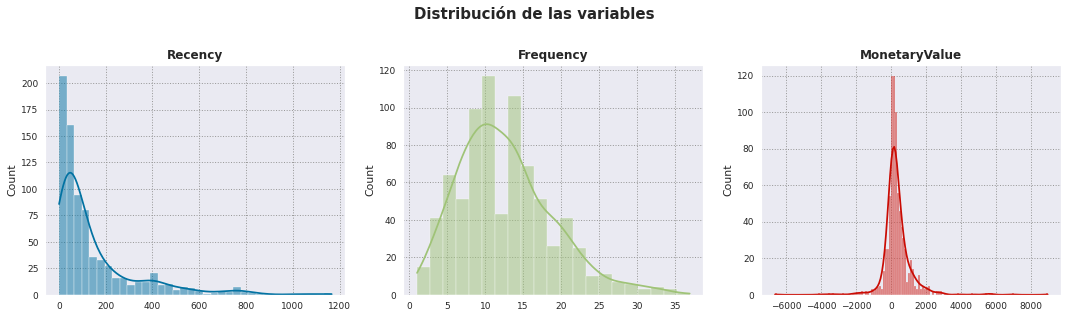

In [8]:
%run ../auxiliar_functions/plotDistributions.py
    
plotDistributions(data, 'Distribución de las variables')

#### TRANSFORMACIÓN DE VARIABLES

In [9]:
# Yeo-Johnson Transformation
pt = PowerTransformer(method='box-cox')
ms = MinMaxScaler(feature_range=(-3,3))

transformer = ColumnTransformer(transformers=[('box-cox', pt, ['Recency']),
                              ('standarizer', ms, [1, 2])])

scaled = transformer.fit_transform(data)

# Variables escaladas - DataFrame
scaled = pd.DataFrame(scaled, index=data.index, columns=data.columns)
scaled.sample(5)

,Recency,Frequency,MonetaryValue
Customer ID,,,
JK-15730,0.06,0.17,-0.43
SP-20545,1.20,-1.50,-0.50
VP-21760,-0.02,-0.83,-0.84
AH-10075,-0.60,0.17,-0.34
EM-14065,-0.37,-2.17,-0.44


In [10]:
scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,793.00,0.00,1.00,-2.74,-0.69,-0.02,0.70,2.43
Frequency,793.00,-1.07,1.04,-3.00,-1.83,-1.17,-0.50,3.00
MonetaryValue,793.00,-0.31,0.34,-3.00,-0.44,-0.37,-0.24,3.00


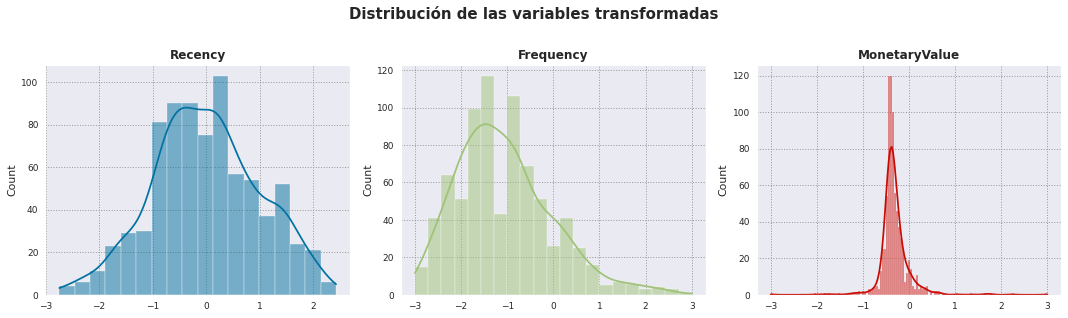

In [11]:
plotDistributions(scaled, 'Distribución de las variables transformadas')

## KMeans

#### MÉTODO DE CODO

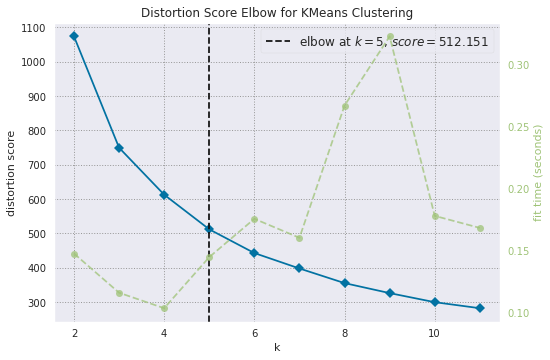

In [12]:
# MÉTODO DE CODO
# ============================================================================

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
plt.show()


#### ENTRENAMIENTO DEL MODELO - KMEANS

In [13]:
# Modelo - KMeans
kmeans_model = KMeans(n_clusters=5)

# Modelo entrenado
kmeans_model.fit_transform(scaled)

data['ClusterLabels_k5'] = kmeans_model.labels_

kmeansData = data.groupby('ClusterLabels_k5').agg({'Recency':'mean',
                                           'Frequency':'mean',
                                           'MonetaryValue':['mean','count']})
kmeansData

Recency Frequency MonetaryValue      
                    mean      mean          mean count
ClusterLabels_k5                                      
0                 466.48      6.82        153.60   131
1                 170.27     14.60        473.41   175
2                  19.73     12.70        403.31   175
3                  66.90     23.07        601.66   125
4                  77.47      7.70        201.29   187